In [8]:
from src.magic_pen.data.loader import BiTemporalDataset
from src.commons.constants import NamedDataset
from src.segment_any_change.utils import show_img, show_pair_img
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import torch
import rasterio as rio
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F


In [9]:
os.cpu_count()

96

In [10]:
pl.seed_everything(seed=SEED)

2024-06-13 08:55:25,912 - INFO ::  Seed set to 12


12

### Inference on selected batch

In [11]:
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from torchmetrics import Metric
from tqdm import tqdm
from src.segment_any_change.inference import load_partial_ds
from src.segment_any_change.config_run import load_default_exp_params
import torch
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from src.segment_any_change.utils import to_numpy, SegAnyChangeVersion


In [19]:
params=None
batch_size= 2
ds_name= "levir-cd"
dtype= "test"
dev=False # vit_h - full grid | vit_b - small grid points
dummy: bool=False
return_batch=True
in_metrics= None
seganychange_version=SegAnyChangeVersion.AUTHOR

idx_batch_bug = 10 #45
indices = np.arange((idx_batch_bug * batch_size-2),(idx_batch_bug * batch_size+2))

In [8]:
init_params = dict(
    batch_size=batch_size,
    ds_name=ds_name,
    n_job_by_node=1,
    dev=dev,
    seganychange_version=seganychange_version
)
if params is None:
    params = load_exp_params(**init_params)
    
model = choose_model(is_debug=dummy, params=params)

ds = load_partial_ds(params.ds_name, dtype, indices)

print(f"len ds : {len(ds)}")

if in_metrics is None:
    in_metrics = load_default_metrics(**params.engine_metric)

engine_eval = MetricEngine(in_metrics=in_metrics)

dloader = torch.utils.data.DataLoader(ds, batch_size=params.batch_size, shuffle=False)
batch_list = []
pred_list = []
for i, batch in tqdm(enumerate(dloader), total=len(dloader), desc="Processing"):
    with torch.no_grad():
        pred_list.append(model(batch))
        batch_list.append(batch)

2024-06-12 19:08:07,668 - INFO ::  build vit_h BiSam


DATASET SUBSET : 2
len ds : 2


Processing:   0%|                                                                    | 0/1 [00:00<?, ?it/s]2024-06-12 19:08:14,437 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
Function forward Took 24.8770 seconds
sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([4, 1024, 256, 64, 64])
pos_src : torch.Size([4, 1024, 256, 64, 64])
tokens : torch.Size([4, 1024, 7, 256])
Function predict_masks_batch Took 46.5281 seconds
filter iou_th : 1046
 filter stability_score : 558
 filter mask_threshold : 558
ATTACH 102 masks
filter iou_th : 1347
 filter stability_score : 572
 filter mask_threshold : 572
ATTACH 130 masks
filter iou_th : 968
 filter stability_score : 497
 filter mask_threshold : 497
ATTACH 266 masks
filter iou_th : 1224
 filter stability_score : 455
 filter mask_threshold : 455
ATTACH 118 masks


2024-06-12 19:09:30,961 - INFO ::  Function generate Took 76.5228 seconds
2024-06-12 19:09:32,527 - INFO ::  Function temporal_matching_torch Took 1.5428 seconds
Processing:   0%|                                                                    | 0/1 [01:18<?, ?it/s]


RuntimeError: The size of tensor a (2) must match the size of tensor b (264) at non-singleton dimension 0

In [ ]:
# why it's blocked ???
# check return : bbox and masks
# counts number diff after batrched_nms

In [ ]:
bboxes = np.array([[1, 2, 5, 6], [10, 20, 50, 60]])
bboxes = np.repeat(bboxes, 3, axis=0)
arr = np.expand_dims(np.random.randint(0, 10, bboxes.shape[0]), axis=1)
print(arr)
noise = np.repeat(arr, bboxes.shape[1], axis=1)
res = bboxes + noise

In [ ]:
np.expand_dims(res, axis=0).repeat(2, axis=0)

### Review torch process (batch)

In [12]:
from segment_any_change.masks.mask_generator import SegAnyMaskGenerator
from typing import Any, Dict, List, Tuple
from deprecated import deprecated
from dataclasses import asdict
from tqdm import tqdm
from segment_any_change.embedding import (
    compute_mask_embedding,
    compute_mask_embedding_torch,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_generator import SegAnyMaskGenerator
from segment_any_change.masks.mask_items import (
    FilteringType,
    ImgType,
    ItemProposal,
    ListProposal,
    create_empty_item,
    create_union_object,
)
from segment_any_change.model import BiSam
from segment_any_change.utils import load_sam
from magic_pen.config import DEVICE
from segment_any_change.matching import extract_bboxes, extract_ious, extract_masks, temporal_matching_torch

In [23]:
params=None
batch_size= 4
ds_name= "levir-cd"
dtype= "test"
dev=True # vit_h - full grid | vit_b - small grid points
seganychange_version=SegAnyChangeVersion.AUTHOR

idx_batch_bug = 10 #45
indices = np.arange((idx_batch_bug * batch_size-2),(idx_batch_bug * batch_size+2))
init_params = dict(
    batch_size=batch_size,
    ds_name=ds_name,
    n_job_by_node=1,
    dev=dev,
    seganychange_version=seganychange_version
)

In [24]:
init_params

{'batch_size': 4,
 'ds_name': 'levir-cd',
 'n_job_by_node': 1,
 'dev': True,
 'seganychange_version': <SegAnyChangeVersion.AUTHOR: 'v2'>}

In [25]:

if params is None:
    params = load_exp_params(**init_params)
    
ds = load_partial_ds(params.ds_name, dtype, indices)

print(f"len ds : {len(ds)}")
print(params.model_type)

model = load_sam(
    model_type=params.model_type, model_cls=BiSam, version="dev", device=DEVICE
)

mask_generator = SegAnyMaskGenerator(model, **asdict(params))

dloader = torch.utils.data.DataLoader(ds, batch_size=params.batch_size, shuffle=False)
batch = next(iter(dloader))

img_anns = mask_generator.generate(batch)
batch_size = mask_generator.batch_size

masks = extract_masks(img_anns)
masks_A, masks_B = masks[:batch_size], masks[batch_size:]

bboxes = extract_bboxes(img_anns)
bboxes_A, bboxes_B = bboxes[:batch_size], bboxes[batch_size:]

ious = extract_ious(img_anns)
ious_A, ious_B = ious[:batch_size], ious[batch_size:]

img_embedding_A = get_img_embedding_normed(mask_generator, ImgType.A)
img_embedding_B = get_img_embedding_normed(mask_generator, ImgType.B)

print(f"img_embedding : {img_embedding_A.shape}")

print(f"img_embedding : {img_embedding_A.dtype}")

assert len(masks_A) == len(masks_B)  # same size_batch
assert len(img_embedding_A) == len(img_embedding_B)

DATASET SUBSET : 4
len ds : 4
vit_b


2024-06-13 08:58:02,028 - INFO ::  build vit_b BiSam


BATCH SIZE : 4 * 2
Function forward Took 11.5487 seconds
sparse_embeddings: torch.Size([8, 25, 2, 256])
dense_embeddings: torch.Size([8, 25, 256, 64, 64])
--in transformer--
src : torch.Size([8, 25, 256, 64, 64])
pos_src : torch.Size([8, 25, 256, 64, 64])
tokens : torch.Size([8, 25, 7, 256])
Function predict_masks_batch Took 3.4369 seconds
filter iou_th : 11
 filter stability_score : 4
 filter mask_threshold : 4
ATTACH 3 masks
filter iou_th : 9
 filter stability_score : 6
 filter mask_threshold : 6
ATTACH 3 masks
filter iou_th : 19
 filter stability_score : 3
 filter mask_threshold : 3
ATTACH 3 masks
filter iou_th : 16
 filter stability_score : 8
 filter mask_threshold : 8
ATTACH 5 masks
filter iou_th : 5
 filter stability_score : 0
 filter mask_threshold : 0
ATTACH 0 masks
filter iou_th : 11
 filter stability_score : 6
 filter mask_threshold : 6
ATTACH 4 masks
filter iou_th : 19
 filter stability_score : 5
 filter mask_threshold : 5
ATTACH 4 masks
filter iou_th : 5
 filter stability_s

2024-06-13 08:58:19,253 - INFO ::  Function generate Took 15.2970 seconds


img_embedding : torch.Size([4, 256, 64, 64])
img_embedding : torch.float32


In [28]:
ious.shape

torch.Size([8, 5])

In [29]:
# t -> t+1
x_t_mA, _, ci = temporal_matching_torch(img_embedding_A, img_embedding_B, masks_A)
# t+1 -> t
_, x_t1_mB, ci1 = temporal_matching_torch(img_embedding_A, img_embedding_B, masks_B)

2024-06-13 08:59:09,767 - INFO ::  Function temporal_matching_torch Took 3.9715 seconds
2024-06-13 08:59:13,376 - INFO ::  Function temporal_matching_torch Took 3.6080 seconds


In [30]:
masks = torch.cat([masks_A, masks_B], dim=0)
confidence_scores = torch.cat([ci, ci1], dim=0)
bboxes = torch.cat([bboxes_A, bboxes_B], dim=0)
iou_preds = torch.cat([ious_A, ious_B], dim=0)

In [31]:
print(f"masks : {masks.shape}")
#print(f"ci : {confidence_scores.shape}")
print(f"bboxes : {bboxes.shape}")
print(f"ious : {iou_preds.shape}")

masks : torch.Size([8, 5, 1024, 1024])
bboxes : torch.Size([8, 5, 4])
ious : torch.Size([8, 5])


In [32]:
from segment_any_change.sa_dev.utils.amg import MaskData
from torchvision.ops.boxes import batched_nms

# use SAM data structure for simplifity
# B x N x 
batch_size, masks_per_img = masks.shape[0], masks.shape[1]

data = MaskData(
    masks=masks.flatten(0, 1),
    bboxes=bboxes.flatten(0, 1),
    ci=confidence_scores.flatten(0, 1), # change ci shape to (B, N),
    iou_preds=iou_preds.flatten(0, 1),
    id_track = torch.arange(masks.shape[0]*masks.shape[1]),
    batch_indices=torch.arange(batch_size).repeat_interleave(masks_per_img)  # (B*N,)

    )

In [33]:
data["masks"].shape

torch.Size([40, 1024, 1024])

In [34]:

keep_by_nms = batched_nms(
    data["bboxes"].float(),
    data["iou_preds"],
    torch.zeros_like(data["bboxes"][:, 0]),  # categories
    iou_threshold=0.8, # default SAM : 0.7 for iou - for ci need to search
)
data.filter(keep_by_nms)

In [35]:
keep_by_nms

tensor([ 5, 15, 30,  0,  1,  6, 16, 10, 17, 18,  7,  2, 19, 25, 11, 12, 31, 26,
        32, 33, 27, 28, 35, 36,  3,  4,  8,  9, 13, 14, 20, 21, 22, 23, 24, 29,
        34, 37, 38, 39])

In [18]:
data["batch_indices"]

tensor([0, 1, 0, 1, 0, 1, 2, 3, 2, 1, 2, 2, 3, 3, 3])

In [19]:
data["id_track"]

tensor([ 1,  5,  2,  7,  0,  4, 11, 15,  8,  6,  9, 10, 12, 13, 14])

In [36]:
from collections import defaultdict

batch_indices = data["batch_indices"]

batch_data = defaultdict(list)
for idx, batch_idx in enumerate(batch_indices):
    batch_data[batch_idx.item()].append(idx)

reshaped_data = {
    'masks': [],
    'bboxes': [],
    'ci': [],
    'iou_preds': []
}
print(batch_data)
for i in range(batch_size):
    if i in batch_data:
        indices = batch_data[i]
        reshaped_data['masks'].append(data['masks'][indices])
        reshaped_data['bboxes'].append(data['bboxes'][indices])
        reshaped_data['ci'].append(data['ci'][indices])
        reshaped_data['iou_preds'].append(data['iou_preds'][indices])
    else:
        # if any of the masks for a img is retains - extrem case
        reshaped_data['masks'].append(torch.empty(0, *data['masks'].shape[1:]))
        reshaped_data['bboxes'].append(torch.empty(0, *data['bboxes'].shape[1:]))
        reshaped_data['ci'].append(torch.empty(0, *data['ci'].shape[1:]))
        reshaped_data['iou_preds'].append(torch.empty(0, *data['iou_preds'].shape[1:]))

defaultdict(<class 'list'>, {1: [0, 5, 10, 26, 27], 3: [1, 6, 8, 9, 12], 6: [2, 16, 18, 19, 36], 0: [3, 4, 11, 24, 25], 2: [7, 14, 15, 28, 29], 5: [13, 17, 20, 21, 35], 7: [22, 23, 37, 38, 39], 4: [30, 31, 32, 33, 34]})


In [37]:
len(reshaped_data["masks"])

8

In [38]:
print([_.shape for _ in reshaped_data['ci']])

[torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5])]


In [39]:
print([_.shape for _ in reshaped_data["masks"]])

[torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024]), torch.Size([5, 1024, 1024])]


In [40]:
reshaped_data['masks'] = torch.nn.utils.rnn.pad_sequence(reshaped_data['masks'], batch_first=True)
reshaped_data['bboxes'] = torch.nn.utils.rnn.pad_sequence(reshaped_data['bboxes'], batch_first=True)
reshaped_data['ci'] = torch.nn.utils.rnn.pad_sequence(reshaped_data['ci'], batch_first=True)
reshaped_data['iou_preds'] = torch.nn.utils.rnn.pad_sequence(reshaped_data['iou_preds'], batch_first=True)

In [41]:
reshaped_data["masks"].shape

torch.Size([8, 5, 1024, 1024])

In [42]:
reshaped_data["masks"].sum(dim=(2, 3))

tensor([[19290, 48595, 14073,     0,     0],
        [60757, 17249,   914,     0,     0],
        [ 3171,  2126,  1467,     0,     0],
        [24566,  1655,  1225,  3499,   467],
        [    0,     0,     0,     0,     0],
        [ 3091,   914,   139,   390,     0],
        [ 4084,  1366,  1196,   649,     0],
        [ 1069,  2936,     0,     0,     0]])

In [43]:
reshaped_data["ci"]

tensor([[-0.7333, -0.6898, -0.7992,     nan,     nan],
        [-0.8443, -0.9064, -0.5091,     nan,     nan],
        [-0.4196, -0.5869, -0.5645,     nan,     nan],
        [-0.9022, -0.7009, -0.4986, -0.8256, -0.5853],
        [    nan,     nan,     nan,     nan,     nan],
        [-0.6817, -0.5034, -0.3701, -0.7264,     nan],
        [-0.8201, -0.4337, -0.6563, -0.4533,     nan],
        [-0.6597, -0.6221,     nan,     nan,     nan]])

In [44]:
masks.sum(dim=(2, 3))

tensor([[19290, 48595, 14073,     0,     0],
        [60757, 17249,   914,     0,     0],
        [ 3171,  2126,  1467,     0,     0],
        [24566,  1655,  1225,  3499,   467],
        [    0,     0,     0,     0,     0],
        [ 3091,   914,   139,   390,     0],
        [ 4084,  1366,  1196,   649,     0],
        [ 1069,  2936,     0,     0,     0]])

In [45]:
confidence_scores

tensor([[-0.7333, -0.6898, -0.7992,     nan,     nan],
        [-0.8443, -0.9064, -0.5091,     nan,     nan],
        [-0.4196, -0.5869, -0.5645,     nan,     nan],
        [-0.9022, -0.7009, -0.4986, -0.8256, -0.5853],
        [    nan,     nan,     nan,     nan,     nan],
        [-0.6817, -0.5034, -0.3701, -0.7264,     nan],
        [-0.8201, -0.4337, -0.6563, -0.4533,     nan],
        [-0.6597, -0.6221,     nan,     nan,     nan]])

In [46]:
bboxes

tensor([[[ 695,  830,  802, 1023],
         [ 375,  190,  718,  388],
         [ 376,  692,  586,  791],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 440,  483,  761,  757],
         [ 589,  850,  808,  972],
         [ 270,   85,  309,  120],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 265,   45,  329,  111],
         [ 895,  450,  936,  538],
         [ 898,  477,  936,  538],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 442,    0,  693,  179],
         [ 681,  265,  722,  325],
         [  84,  504,  114,  557],
         [  46,   67,  123,  132],
         [ 506,  902,  529,  928]],

        [[   0,    0,    0,    0],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 298,  503,  392,  549],
         [ 271,   81,  311,  110],
         [ 101,  298,  113,  310],
         [

In [47]:
data["bboxes"]

tensor([[ 440,  483,  761,  757],
        [ 442,    0,  693,  179],
        [ 453,  286,  536,  356],
        [ 695,  830,  802, 1023],
        [ 375,  190,  718,  388],
        [ 589,  850,  808,  972],
        [ 681,  265,  722,  325],
        [ 265,   45,  329,  111],
        [  84,  504,  114,  557],
        [  46,   67,  123,  132],
        [ 270,   85,  309,  120],
        [ 376,  692,  586,  791],
        [ 506,  902,  529,  928],
        [ 298,  503,  392,  549],
        [ 895,  450,  936,  538],
        [ 898,  477,  936,  538],
        [ 281,   85,  326,  121],
        [ 271,   81,  311,  110],
        [ 501,  892,  546,  926],
        [ 908,  307,  943,  329],
        [ 101,  298,  113,  310],
        [ 918,   98,  941,  121],
        [ 299,  303,  344,  330],
        [ 917,   78, 1023,  150],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,

In [48]:
reshaped_data["bboxes"]

tensor([[[ 695,  830,  802, 1023],
         [ 375,  190,  718,  388],
         [ 376,  692,  586,  791],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 440,  483,  761,  757],
         [ 589,  850,  808,  972],
         [ 270,   85,  309,  120],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 265,   45,  329,  111],
         [ 895,  450,  936,  538],
         [ 898,  477,  936,  538],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 442,    0,  693,  179],
         [ 681,  265,  722,  325],
         [  84,  504,  114,  557],
         [  46,   67,  123,  132],
         [ 506,  902,  529,  928]],

        [[   0,    0,    0,    0],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0],
         [   0,    0,    0,    0]],

        [[ 298,  503,  392,  549],
         [ 271,   81,  311,  110],
         [ 101,  298,  113,  310],
         [

### Change Thresholding

In [49]:
data["ci"]

tensor([-0.8443, -0.9022, -0.8201, -0.7333, -0.6898, -0.9064, -0.7009, -0.4196,
        -0.4986, -0.8256, -0.5091, -0.7992, -0.5853, -0.6817, -0.5869, -0.5645,
        -0.4337, -0.5034, -0.6563, -0.4533, -0.3701, -0.7264, -0.6597, -0.6221,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan])

In [50]:
data._stats.keys()

dict_keys(['masks', 'bboxes', 'ci', 'iou_preds', 'id_track', 'batch_indices'])

In [51]:
torch.where(data["ci"] > -0.6)

(tensor([ 7,  8, 10, 12, 14, 15, 16, 17, 19, 20]),)

In [52]:
from typing import Union
from skimage.filters import threshold_otsu

def change_thresholding(data, method: Union[str, float]) -> Any:
    method_factory = {
        "otsu": apply_otsu,
        "th": apply_th,
    }
    params = {}
    data_ = deepcopy(data)
    
    if (method not in method_factory and isinstance(method, str)) or method is None:
        raise ValueError(
            f"Please provide valid filtering method : {list(method_factory)}"
        )
    if isinstance(method, (float, int)):
        params["th"] = method
        method = "th"

    data_, th = method_factory[method](data_, **params)
    return data_, th

def apply_otsu(
    data: MaskData,
) -> Tuple[MaskData, float]:
    # set otsu threshold on batch
    arr = to_numpy(data["chgt_angle"], transpose=False)
    th = threshold_otsu(arr[~np.isnan(arr)])
    print(th)
    return apply_th(data, th)


def apply_th(
    data: MaskData, th: float
) -> Tuple[MaskData, float]:
    keep_indices = torch.where(data["chgt_angle"] > th)[0]
    data.filter(keep_indices)
    return data, th

In [53]:
from segment_any_change.utils import to_degre_torch
data["chgt_angle"] = to_degre_torch(data["ci"])

In [54]:
data_, th = change_thresholding(data, method=60)

In [55]:
data["chgt_angle"]

tensor([32.4039, 25.5486, 34.9062, 42.8332, 46.3820, 24.9863, 45.5022, 65.1878,
        60.0937, 34.3461, 59.3944, 36.9442, 54.1790, 47.0254, 54.0659, 55.6317,
        64.2976, 59.7779, 48.9823, 63.0429, 68.2754, 43.4124, 48.7240, 51.5322,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan])

In [56]:
data_["ci"]

tensor([-0.4196, -0.4986, -0.4337, -0.4533, -0.3701])

In [57]:
data_["batch_indices"]

tensor([2, 3, 6, 6, 5])

In [58]:
arr = to_numpy(data["chgt_angle"], transpose=False)
arr[~np.isnan(arr)]

array([32.403927, 25.548561, 34.906208, 42.83318 , 46.382046, 24.986343,
       45.502186, 65.18782 , 60.093716, 34.34609 , 59.394375, 36.944183,
       54.178986, 47.025436, 54.06589 , 55.631737, 64.29764 , 59.777885,
       48.982307, 63.0429  , 68.275375, 43.41238 , 48.724014, 51.532246],
      dtype=float32)

In [59]:
keep = torch.where(data["chgt_angle"] > 100)[0]

In [60]:
data.filter(keep)

In [61]:
data["masks"]

tensor([], size=(0, 1024, 1024), dtype=torch.uint8)

In [62]:
to_degre_torch(data["ci"])

tensor([])

#### unit tests

In [62]:
x_t.shape

torch.Size([2, 4, 256])

In [112]:
x_tu = x_t[0, 0, :]
x_t1u = x_t1[0, 0, :]

In [117]:
r = x_tu @ x_t1u 
print("dot prod", r)
print("scaler", (torch.linalg.norm(x_tu) * torch.linalg.norm(x_t1u)))
r / (torch.linalg.norm(x_tu) * torch.linalg.norm(x_t1u))

dot prod tensor(99.3079, grad_fn=<DotBackward0>)
scaler tensor(140.0314, grad_fn=<MulBackward0>)


tensor(0.7092, grad_fn=<DivBackward0>)

In [41]:
print(torch.linalg.norm(x_t, dim=2))
#print(torch.linalg.norm(x_t1))

tensor([[13.1428,  9.6276, 11.0536, 10.9635],
        [11.6520,  9.7441,     nan, 11.8824]],
       grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
-(x_t @ x_t1.permute(0, 2, 1)) / (torch.linalg.norm(x1) * torch.linalg.norm(x2))

In [18]:
# t -> t+1
x_t_mA, _, ci = temporal_matching_torch(img_embedding_A, img_embedding_B, masks_A)
# t+1 -> t
_, x_t1_mB, ci1 = temporal_matching_torch(img_embedding_A, img_embedding_B, masks_B)

2024-06-12 15:59:07,178 - INFO ::  Function temporal_matching_torch Took 2.4858 seconds
2024-06-12 15:59:09,163 - INFO ::  Function temporal_matching_torch Took 1.9825 seconds


In [19]:
x_t_mA

tensor([[[-0.6117, -1.4318, -0.6239,  ...,  0.9148,  0.2488,  0.1562],
         [ 0.0382, -0.7627, -0.2582,  ...,  0.6390,  0.0947,  0.0543],
         [ 0.2199, -1.2118, -0.2892,  ...,  0.2713, -0.1662,  0.1542],
         [-0.6489, -1.1664, -0.6414,  ...,  0.9022, -0.1198,  0.0678]],

        [[ 0.1444, -0.7530,  0.0294,  ...,  0.6605, -0.4145,  0.2712],
         [-0.5073, -0.7343, -0.6276,  ...,  0.7395, -0.0722,  0.1222],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-0.3599, -1.0464, -0.4010,  ...,  0.3910,  0.1106, -0.1712]]],
       grad_fn=<PermuteBackward0>)

In [21]:
x_t1_mB

tensor([[[-0.8701, -1.1233,  0.2066,  ...,  1.2144,  0.5662,  0.1541],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-1.0250, -1.0752, -0.2553,  ...,  1.5109,  0.1376,  0.3192]],

        [[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-0.3306, -1.0101,  0.2416,  ...,  1.0746,  0.6002,  0.2232]]],
       grad_fn=<PermuteBackward0>)

In [22]:
ci.shape

torch.Size([2, 4])

In [23]:
ci1

tensor([[-0.7724,     nan,     nan, -0.5616],
        [    nan,     nan,     nan, -0.5156]], grad_fn=<DivBackward0>)

In [15]:
x_t.permute(0, 2, 1).shape

torch.Size([2, 4, 256])

In [16]:
x_t.permute(0, 2, 1).sum(dim=2)

tensor([[-3.8147e-06, -3.0994e-06,  1.4305e-06,  5.7220e-06],
        [-1.2159e-05, -4.2915e-06,         nan, -1.5736e-05]],
       grad_fn=<SumBackward1>)

In [19]:
x_t.permute(0, 2, 1)[0, 3].sum()

tensor(4.2915e-06, grad_fn=<SumBackward0>)

In [24]:
x_t.permute(0, 2, 1)[0, 0, :]

tensor([-6.1167e-01, -1.4318e+00, -6.2389e-01,  9.1043e-02, -7.1337e-03,
         8.0430e-01, -5.3782e-02,  6.6810e-02,  6.7740e-01,  6.6383e-01,
         5.2076e-01,  7.5615e-02,  9.4822e-01,  5.4496e-01,  7.7735e-01,
         7.6503e-01, -1.8653e-03, -1.3823e+00,  9.5998e-02, -3.7683e-01,
        -4.8386e-02,  8.4525e-01,  2.0731e-01,  6.5089e-01,  7.2767e-02,
        -5.0068e-01, -1.5678e+00,  7.6396e-01, -4.4920e-02, -4.2269e-01,
        -3.0021e-01, -1.7884e-01,  4.6480e-01, -7.8293e-01,  9.2259e-01,
        -1.3270e+00,  1.5178e-02, -6.5273e-01,  1.6092e-01,  5.1863e-01,
        -6.5035e-01,  3.4131e-01, -5.1002e-01, -8.9582e-01, -3.0454e-01,
         3.6027e-01,  9.6706e-01,  1.7207e-01,  7.6441e-01, -5.2295e-01,
        -4.0523e-01, -7.1736e-01, -3.2573e-01, -9.9066e-01,  8.8492e-01,
        -7.6363e-02, -6.9952e-01, -7.8171e-02,  8.1751e-01, -7.8222e-01,
        -3.1603e-01, -2.5406e-01,  2.2149e-01,  1.1691e+00, -1.0806e-01,
        -4.0000e-01,  7.0856e-01, -4.2485e-02, -8.2

In [20]:
from segment_any_change.matching import neg_cosine_sim_torch
chg_ci = neg_cosine_sim_torch(x_t, x_t1)


In [21]:
chg_ci

tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]])

In [11]:
masks_A.shape

torch.Size([2, 4, 1024, 1024])

In [12]:
img_embedding_A.shape

torch.Size([2, 256, 64, 64])

In [13]:
x_t.shape

torch.Size([2, 4, 1024])

In [14]:
chg_ci = neg_cosine_sim_torch(x_t, x_t1)

NameError: name 'neg_cosine_sim_torch' is not defined

RuntimeError: linalg.vector_norm: Expected a floating point or complex tensor as input. Got Byte

In [ ]:
print(ci.shape)
print(ci1.shape)
print(x_t_mA.shape)
print(x_t1_mB.shape)

In [10]:
img_anns[0]["masks"].shape

torch.Size([3, 1024, 1024])

In [11]:
len(img_anns)

4

In [33]:
img_anns[3]["masks"].shape

torch.Size([4, 1024, 1024])

In [41]:
from torchvision.utils import make_grid
from torch.nn.utils.rnn import pad_sequence
res = pad_sequence([anns["masks"] for anns in img_anns])

In [42]:
res.shape

torch.Size([4, 4, 1024, 1024])

In [39]:
ious = pad_sequence([anns["predicted_iou"] for anns in img_anns])

In [40]:
ious.shape

torch.Size([4, 4])

In [35]:
res.shape

torch.Size([4, 4, 1024, 1024])

In [36]:
res = res.to(torch.uint8)

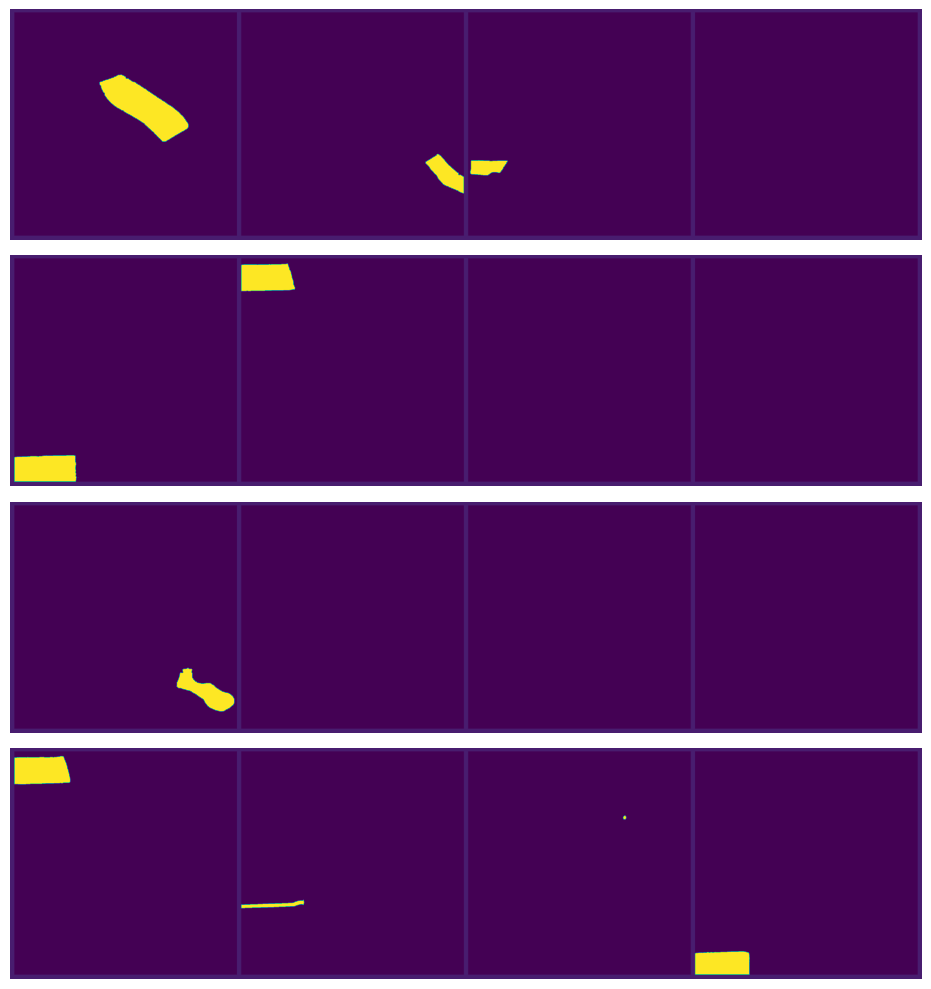

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(25, 10))
axes = axes.ravel()
grid = make_grid(res*255, nrow=4, padding=20, pad_value=20)

for i, ax in enumerate(axes):
    axes[i].imshow(grid[i])
    axes[i].set_axis_off()
plt.tight_layout()

#### Review temporal proposal

In [7]:
t = torch.as_tensor(np.array([[1, 2, 65], [2, 73, 4], [1, 119, 4]])).to(torch.float)
t = t.unsqueeze(0).repeat(3, 1, 1)

t1 = torch.as_tensor(np.array([[99, 1, 2], [43, 6, 38], [11, 34, 78]])).to(torch.float)
t1 = t1.unsqueeze(0).repeat(3, 1, 1)

t_batch = torch.stack([t, t1])
t_batch = t_batch.repeat(2, 1, 1, 1)

In [8]:
t_batch = torch.where(t_batch > 39., 1, 0)

In [9]:
t_batch.shape

torch.Size([4, 3, 3, 3])

In [10]:
img_embedding = torch.rand((4, 10, 3, 3)).to(torch.float)

In [11]:
img_embedding.shape

torch.Size([4, 10, 3, 3])

In [12]:
(img_embedding[:,:,None,...] * t_batch[:,None,...]).shape

torch.Size([4, 10, 3, 3, 3])

In [13]:
res = (img_embedding[:,:,None,...] * t_batch[:, None,...])

In [14]:
torch.linalg.norm(res)

tensor(10.9001)

In [84]:
t_batch[0, 0]

tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]])

In [93]:
res[0, 0, 0, ...]

tensor([[0.0000, 0.0000, 0.1384],
        [0.0000, 0.5381, 0.0000],
        [0.0000, 0.6378, 0.0000]])

In [15]:
emb_m = torch.nanmean(res, dim=(2, 3))

In [16]:
emb_m.shape

torch.Size([4, 10, 3])

In [22]:
emb_m2.shape

torch.Size([4, 10, 3])

In [24]:
l =np.arange(10)
l2 = np.arange(10)
l@l2

285

In [18]:
emb_m2 = deepcopy(emb_m)

In [27]:
(emb_m @ emb_m2.permute(0, 2, 1)).shape

torch.Size([4, 10, 10])

### Review matching proposal : with NMS

In [14]:
a = np.array([1, 2, 3, 4])
b = np.array([2, 3, 4, 5])

(a+b)/2

array([1.5, 2.5, 3.5, 4.5])

In [ ]:
from torchvision.ops.boxes import batched_nms
from segment_any_change.sa_dev.utils.amg import MaskData, batched_mask_to_box


In [43]:
items_A = model.items_A
items_B = model.items_B

In [37]:
res = model.mask_generator.generate(batch)

BATCH SIZE : 1 * 2
Function forward Took 14.9917 seconds
sparse_embeddings: torch.Size([2, 1024, 2, 256])
dense_embeddings: torch.Size([2, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([2, 1024, 7, 256])
- In transf src : torch.Size([2, 1024, 4096, 256])
- In transf image_pe : torch.Size([2, 1024, 4096, 256])
Function predict_masks_batch Took 25.7161 seconds
filter iou_th : 1347
 filter stability_score : 572
 filter mask_threshold : 572
ATTACH 130 masks
filter iou_th : 1224
 filter stability_score : 455
 filter mask_threshold : 455
ATTACH 118 masks


2024-06-10 17:22:19,499 - INFO ::  Function generate Took 43.9188 seconds


In [46]:
from segment_any_change.masks.mask_items import (
    ImgType,
    ItemProposal,
    ListProposal,
)
from torchvision.ops.boxes import batched_nms
from segment_any_change.sa_dev.utils.amg import MaskData

# use SAM data structure for simplifity
items = ListProposal((items_A + items_B))

data = MaskData(
    masks=items.masks.flatten(0, 1),
    bboxes=items.bboxes.flatten(0, 1),
    ci=items.confidence_scores.flatten(0, 1),
    iou_preds=items.iou_preds.flatten(0, 1),
)

keep_by_nms = batched_nms(
    data["bboxes"].float(),
    data["iou_preds"],
    torch.zeros_like(data["bboxes"][:, 0]),  # categories
    iou_threshold=nms_threshold, # default SAM : 0.7
)
data.filters(keep_by_nms)
# Keep old data format
items_filtered = [
    ItemProposal(
        mask=m,
        emb=None,
        confidence_score=ci,
        bbox=bbox,
        iou_pred=iou,
    ) for m,ci,bbox,iou in zip(data["masks"], data["ci"], data["bboxes"], data["iou_preds"])]

items_change = ListProposal(items_filtered)

AttributeError: 'ListProposal' object has no attribute 'bboxes'

##### 

In [10]:
from typing import Any, Dict, List, Tuple, Union

def show_prediction_sample(output: Dict):
    masks = output["pred"]["masks"].cpu().squeeze(0)
    img_A = output["batch"]["img_A"].cpu().squeeze(0)
    img_B = output["batch"]["img_B"].cpu().squeeze(0)
    label = output["batch"]["label"].cpu().squeeze(0)

    if masks.ndim == 3:
        masks = torch.sum(masks, dim=0)
    fig, axs = plt.subplots(ncols=4, squeeze=False, figsize=(10, 10))
    
    for i, sample in enumerate(zip([img_A, img_B, label, masks], ["img_A", "img_B", "label", "masks_agg"])):
        img, name = sample
        if name.startswith("im"):
            img = to_numpy(img, transpose=True) / 255
            axs[0, i].imshow(img)

        else:
            img = to_numpy(img, transpose=False)
            axs[0, i].imshow(img, cmap="grey")

        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(name)

In [46]:
def retrieve_sample_from_batch(pred_list, batch_list, idx):
    return [
        {"pred":
         {
             "masks":p["masks"][idx]
         }, 
         "batch": {
             "img_A":b["img_A"][idx],
             "img_B":b["img_B"][idx],
             "label":b["label"][idx]

                  }
        } for p,b in zip(pred_list, batch_list)
    ][0]

In [47]:
len(pred_list)

1

Projection dimension embedding image -> dimension masks 

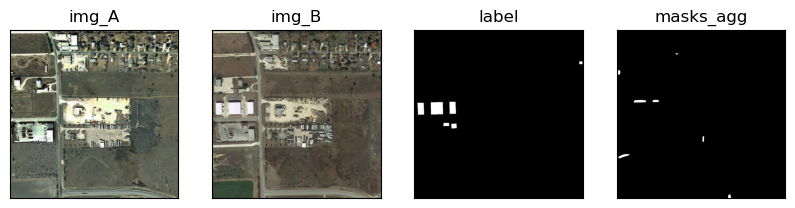

In [48]:
output = retrieve_sample_from_batch(pred_list, batch_list, idx=0)
show_prediction_sample(output)

## Review projection

* now image dim => mask dim

In [71]:
from segment_any_change.embedding import (
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    ImgType,
)
from magic_pen.config import DEVICE

In [131]:
img_embedding_A = get_img_embedding_normed(model.mask_generator, ImgType.A)

In [65]:
img_embedding_A.shape

(256, 64, 64)

In [136]:
def upscale_masks(masks: Union[torch.Tensor, np.ndarray], target_size) -> torch.Tensor:

    if not isinstance(masks, torch.Tensor):
        masks = torch.as_tensor(masks, device=DEVICE)

    if masks.ndim < 4:
        masks = masks.unsqueeze(0)

    masks = F.interpolate(
        masks, target_size, mode="bicubic", align_corners=False
    )
    return to_numpy(masks, transpose=False)

In [138]:
res = upscale_masks(img_embedding_A, (1024, 1024))
res.shape

(1, 256, 1024, 1024)

### Review obj extraction

---

In [18]:
built_labels = torch.zeros((2, 1024, 1024))

In [461]:
built_labels[0,...] = batch_list[0]["label"][0]
built_labels[1,...] = batch_list[0]["label"][1]
built_labels[1, 400:600, 400:600] = 1.
built_labels[1, 800:1000, 800:1000] = 1.

# built_labels[0, 100:300, 100:300] = 1.
# built_labels[0, 450:800, 50:200] = 1.

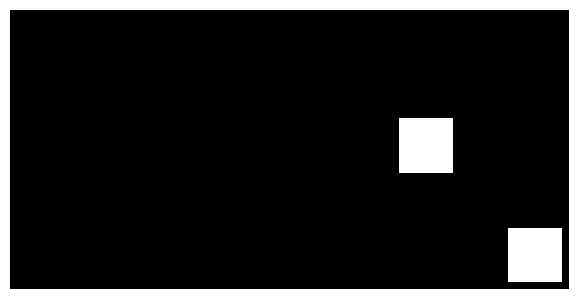

In [462]:
show_img(to_numpy(torch.cat([_ for _ in built_labels], dim=1), transpose=False))

In [463]:
masks= deepcopy(built_labels)

In [464]:
masks.shape

torch.Size([2, 1024, 1024])

In [33]:
torch.sum(masks[0])

tensor(66810.)

In [34]:
torch.sum(masks[1])

tensor(0.)

---

In [19]:
import kornia as K

def remap_values(remapping, x):
    index = torch.bucketize(x.ravel(), remapping[0])
    return remapping[1][index].reshape(x.shape)


# B x 1 x H x W -> B x H x W. Normalize to [0, 1]
labels_masks = K.contrib.connected_components(
    masks.unsqueeze(1).to(torch.float) / torch.max(masks), 
num_iterations=500
).squeeze(1)
# prevent taking background position 0; i.e no change
uniques = torch.unique(labels_masks)
# Labels from K.connected_component are not 0-index based and sequential integers
# Need a mapping for one-hot
print(uniques)
if len(uniques) == 0:
    # masks is fully background - no change
    pass

remapping = uniques, torch.arange(end=len(uniques))
remapped_batch = remap_values(remapping, labels_masks)
# B x H x W => B x N x H x W
m = F.one_hot(remapped_batch.long(), len(uniques)).permute(0, 3, 1, 2)
# remove background mask, i.e no-change
m = m[:, 1:, : , ]

tensor([     0., 458887., 462996.])


In [20]:
masks.shape

torch.Size([2, 1024, 1024])

In [21]:
remapped_batch.shape

torch.Size([2, 1024, 1024])

In [22]:
torch.unique(remapped_batch.view(1, -1), dim=1)

tensor([[0, 1, 2]])

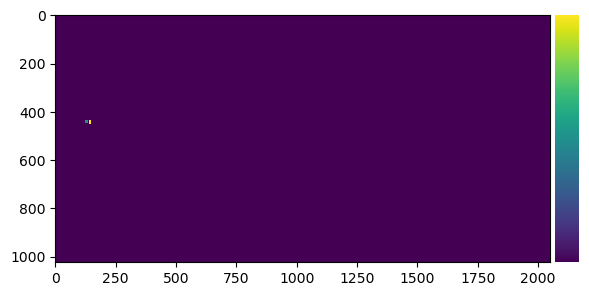

In [23]:
show_img(to_numpy(torch.cat([_ for _ in remapped_batch], dim=1), transpose=False))

In [24]:
torch.unique(remapped_batch[0])

tensor([0, 1, 2])

In [25]:
remapped_batch.shape

torch.Size([2, 1024, 1024])

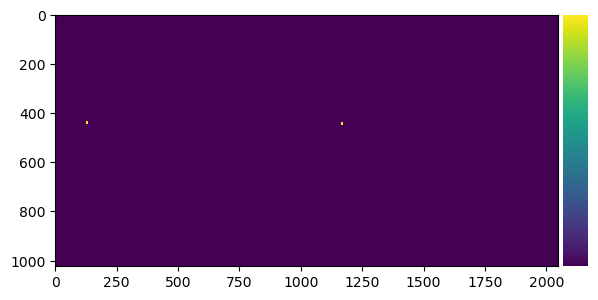

In [26]:
show_img(to_numpy(torch.cat([_ for _ in m[0]], dim=1), transpose=False))

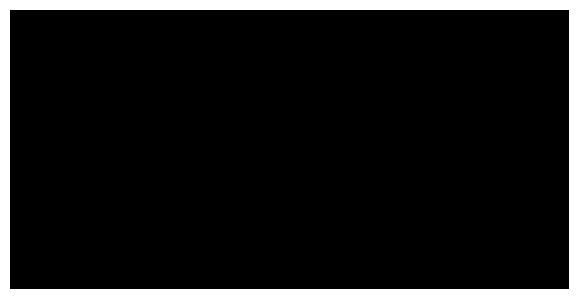

In [27]:
show_img(to_numpy(torch.cat([_ for _ in m[1]], dim=1), transpose=False))

In [347]:
torch.sum(m[0], dim=(1, 2))

tensor([996076,  52500,      0,      0])

In [348]:
torch.sum(m[1], dim=(1, 2))

tensor([968576,      0,  40000,  40000])

In [349]:
remapped_batch.shape

torch.Size([2, 1024, 1024])

In [350]:
torch.unique(labels_masks)

tensor([      0.,  306475.,  818375., 1662551., 2072551.])

In [351]:
torch.unique(remapped_batch)

tensor([0, 1, 2, 3])

In [352]:
masks.shape

torch.Size([2, 1024, 1024])

In [353]:
torch.unique(m[0, 1])

tensor([0, 1])

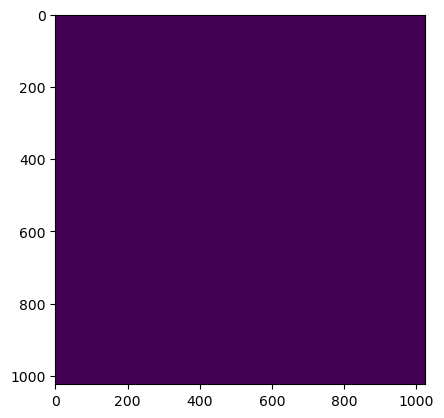

In [354]:
plt.imshow(to_numpy(m[1, 1], transpose=False)*255)

In [117]:
m[1, 400:600, 400:600] = 255

In [114]:
m[0, 400:600, 400:600]

tensor([], size=(0, 200, 1024), dtype=torch.int64)

In [164]:
torch.sum(m[0].squeeze(0))

tensor(1048576)

In [165]:
torch.where(m[0] == 255)

(tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64))

In [166]:
torch.sum(m[1].squeeze(0))

tensor(1048576)

In [ ]:
def extract_object_from_batch(masks: torch.Tensor) -> torch.Tensor:
    """Extract individual mask objects from a batch of masks B x H x W

    Args:
        masks (torch.Tensor): (B x H x W) batch masks

    Returns:
        torch.Tensor: (B x N x H x W) with N total objects of batch
    """
    def remap_values(remapping, x):
        index = torch.bucketize(x.ravel(), remapping[0])
        return remapping[1][index].reshape(x.shape)
    

    # B x 1 x H x W -> B x H x W. Normalize to [0, 1]
    labels_masks = K.contrib.connected_components(
        masks.unsqueeze(1).to(torch.float) / torch.max(masks), 
    num_iterations=500
    ).squeeze(1)
    # prevent taking background position 0; i.e no change
    uniques = torch.unique(labels_masks)[1:]
    # Labels from K.connected_component are not 0-index based and sequential integers
    # Need a mapping for one-hot
    if len(uniques) == 0:
        # masks is fully background - no change
        pass
    remapping = uniques, torch.arange(end=len(uniques))
    remapped_batch = remap_values(remapping, labels_masks)
    # B x H x W => B x N x H x W
    masks = F.one_hot(remapped_batch.long(), len(uniques)).permute(0, 3, 1, 2) 

    return masks

In [ ]:
 metrics = engine_eval(preds, batch["label"])
        out = {
             "preds": preds, 
             "metrics": metrics,
             "batch": batch if return_batch else None
        }
        outputs.append(out)

### Steps

In [34]:
ds = BiTemporalDataset(name=NamedDataset.LEVIR_CD.value, dtype="test", transform=DefaultTransform())

In [35]:
batch_size =2
dloader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)
#batch = next(iter(dloader))

In [36]:
len(ds)

128

In [8]:
selected_i = 2
for i, batch in enumerate(dloader):
    if i == selected_i:
        break

In [9]:
batch["img_A"][0].shape

torch.Size([3, 1024, 1024])

In [10]:
index = selected_i * batch_size
img_A = ds[index]["img_A"]
img_B = ds[index]["img_B"]
label = ds[index]["label"]

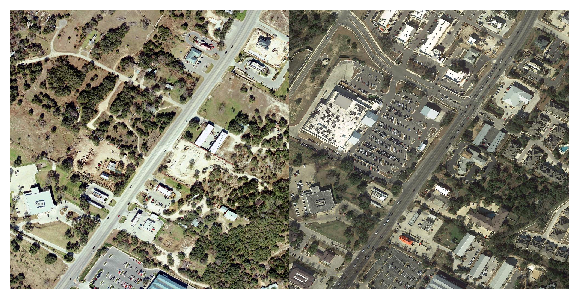

In [11]:
show_pair_img(to_numpy(img_A, transpose=True) / 255, to_numpy(img_B, transpose=True) /255)

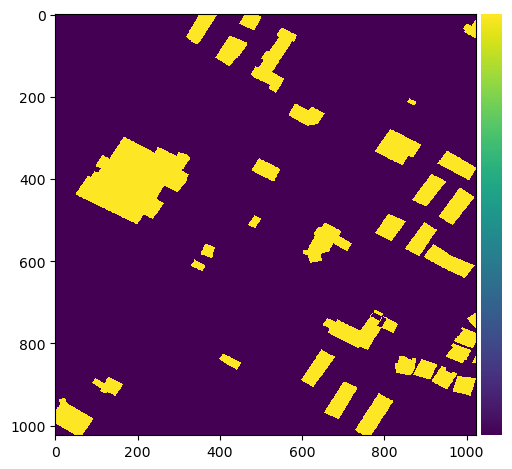

In [12]:
show_img(to_numpy(label, transpose=False))

## Extraction des masques

In [20]:
norm_factor = torch.max(batch["img_A"][0]).item()

labels_masks = K.contrib.connected_components(
    batch["label"].unsqueeze(1).to(torch.float) / norm_factor,
    num_iterations=500
)
# B x 1 x H x W => B x H x W
labels_masks = labels_masks.view(batch_size, *labels_masks.shape[-2:])

In [21]:
from segment_any_change.masks.mask_process import _extract_obj

In [22]:
batch_masks = []
for m in labels_masks:
        batch_masks.append(_extract_obj(m))

shapes : 35
35
shapes : 54
54


In [30]:
def show_batch(batch: Dict[str, torch.Tensor]) -> None:
    n_sample = batch[next(iter(batch))].shape[0]
    fig, axes = plt.subplots(n_sample, 3, figsize=(10, 10))
    norm_factor = torch.max(batch["img_A"][0]).item()

    labels_masks = K.contrib.connected_components(
            batch["label"].unsqueeze(1).to(torch.float) / norm_factor, 
            num_iterations=500

    )
    # B x 1 x H x W => B x H x W
    labels_masks = labels_masks.view(n_sample, *labels_masks.shape[-2:])
    for i in range(n_sample):
        axes[i, 0].imshow(to_numpy(batch["img_A"][i], transpose=True) / norm_factor)
        axes[i, 0].set_axis_off()
        axes[i, 1].imshow(to_numpy(batch["img_B"][i], transpose=True) / norm_factor)
        axes[i, 1].set_axis_off()
        axes[i, 2].imshow(to_numpy(batch["label"][i], transpose=False))
        axes[i, 2].set_axis_off()
        axes[i, 2].set_title(len(torch.unique(labels_masks[i])[1:]))

    """
    fig = plt.figure(constrained_layout=True)
    fig.suptitle('Figure title')
    
    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=3, ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'Subfigure title {row}')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.plot()
        ax.set_title(f'Plot title {col}')
    """
    plt.tight_layout()

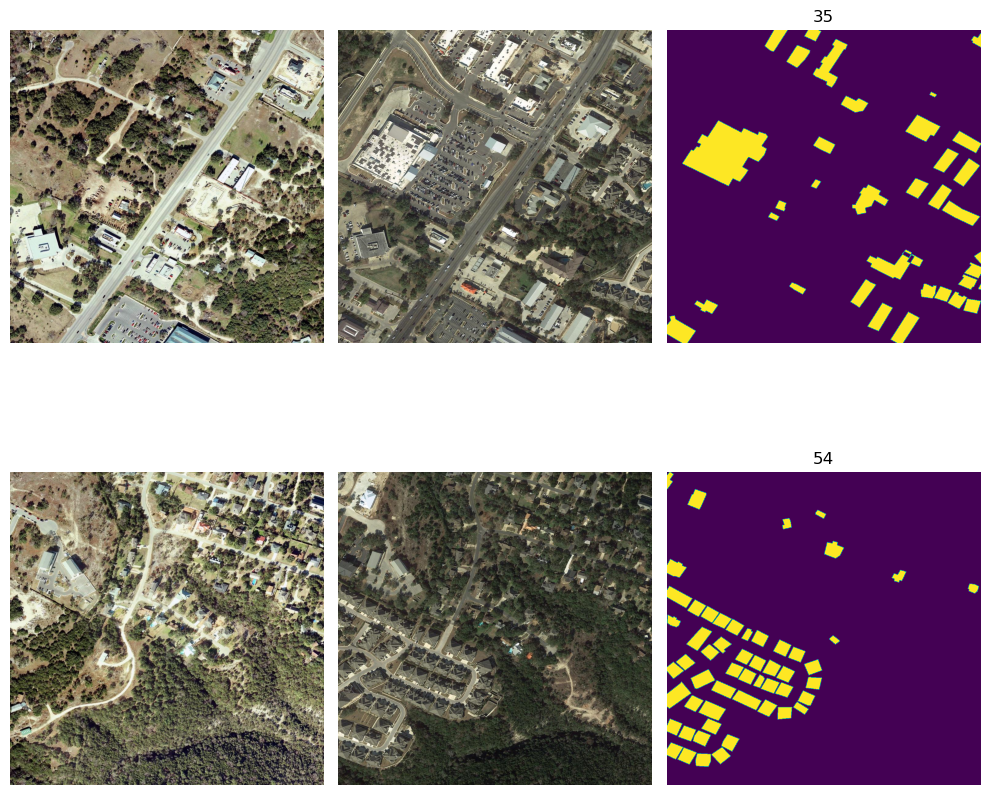

In [31]:
show_batch(batch)

In [ ]:
show_img(to_numpy(batch["img_A"][1], transpose=True)/255)

In [45]:
label.shape

torch.Size([1024, 1024])

In [46]:
label = ds[index]["label"]

In [49]:
# "change to test set"
n_masks = []
for i, batch in enumerate(dloader):
    # print(f"--- {i} ---")
    labels_masks = K.contrib.connected_components(
    batch["label"].unsqueeze(1).to(torch.float) / norm_factor,
            num_iterations=1000
    )
    # B x 1 x H x W => B x H x W
    labels_masks = labels_masks.view(batch_size, *labels_masks.shape[-2:])
    # print(len(torch.unique(labels_masks[0])[1:]))
    # print(len(torch.unique(labels_masks[1])[1:]))
    n_masks.append(len(torch.unique(labels_masks[0])[1:]))
    n_masks.append(len(torch.unique(labels_masks[1])[1:]))

    if i % 50 == 0:
        print(f"--- processed {i} ... ---")


--- processed 0 ... ---
--- processed 50 ... ---


<Axes: >

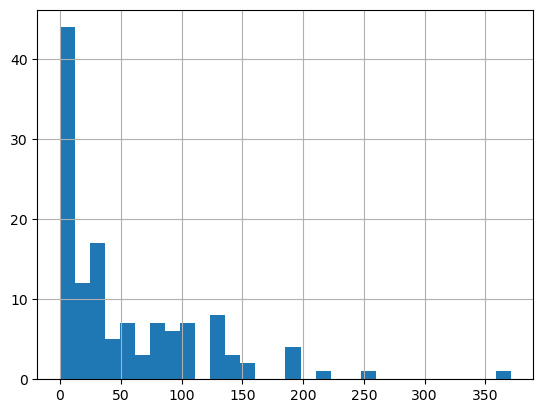

In [50]:
# 1000 iterations
pd.Series(n_masks).hist(bins=30)

<Axes: >

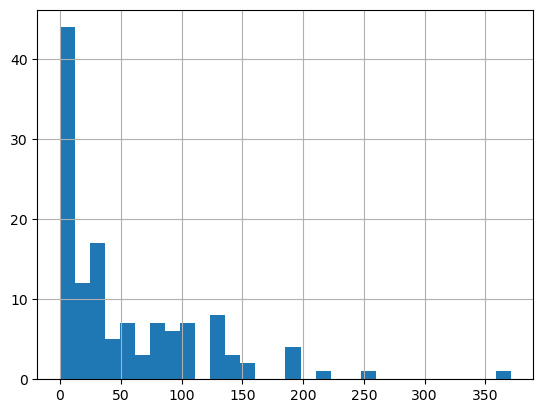

In [40]:
# 500 iterations
pd.Series(n_masks).hist(bins=30)

In [42]:
indices = np.where(np.array(n_masks) > 150)[0]
print(len(indices))
indices

9


array([ 2, 18, 21, 41, 60, 68, 94, 96, 98])

254


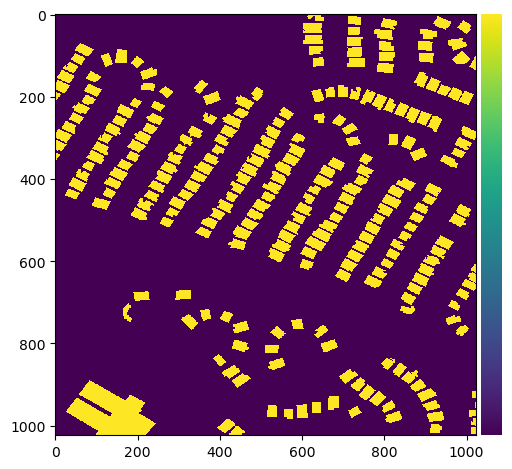

In [48]:
index = 96
print(n_masks[index])
img_A = ds[index]["img_A"]
img_B = ds[index]["img_B"]
label = ds[index]["label"]
show_img(to_numpy(label, transpose=False))

In [53]:
selected_i = index // batch_size
for i, batch in enumerate(dloader):
    if i == selected_i:
        break

In [57]:
labels_masks = K.contrib.connected_components(
batch["label"].unsqueeze(1).to(torch.float) / norm_factor,
        num_iterations=500
)
# B x 1 x H x W => B x H x W
labels_masks = labels_masks.view(batch_size, *labels_masks.shape[-2:])

In [73]:
batch_masks = []
for m in labels_masks:
        batch_masks.append(_extract_obj(m))

shapes : 254
254
shapes : 29
29


In [74]:
batch_masks = batch_masks[0]

In [75]:
batch_masks.shape

torch.Size([254, 1024, 1024])

In [ ]:
show_img(batch_masks[1000])

In [76]:
counts = torch.sum(batch_masks, dim=(1, 2))

In [79]:
pd.Series(counts).describe()

count      254.000000
mean       734.893701
std        983.852362
min         49.000000
25%        569.000000
50%        714.000000
75%        794.000000
max      16145.000000
dtype: float64

In [80]:
smaller_obj_i = torch.argmin(counts)

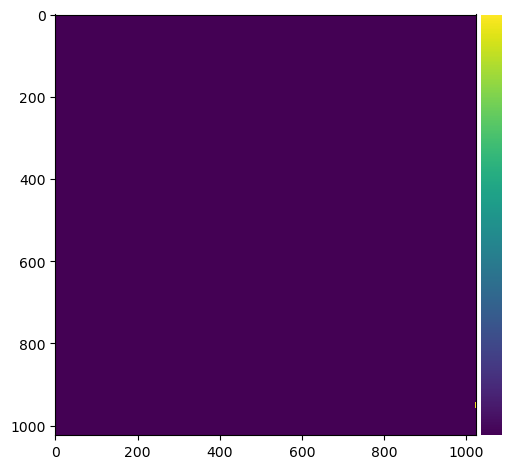

In [83]:
show_img(to_numpy(batch_masks[smaller_obj_i], transpose=False))

Ok cela fait sens !

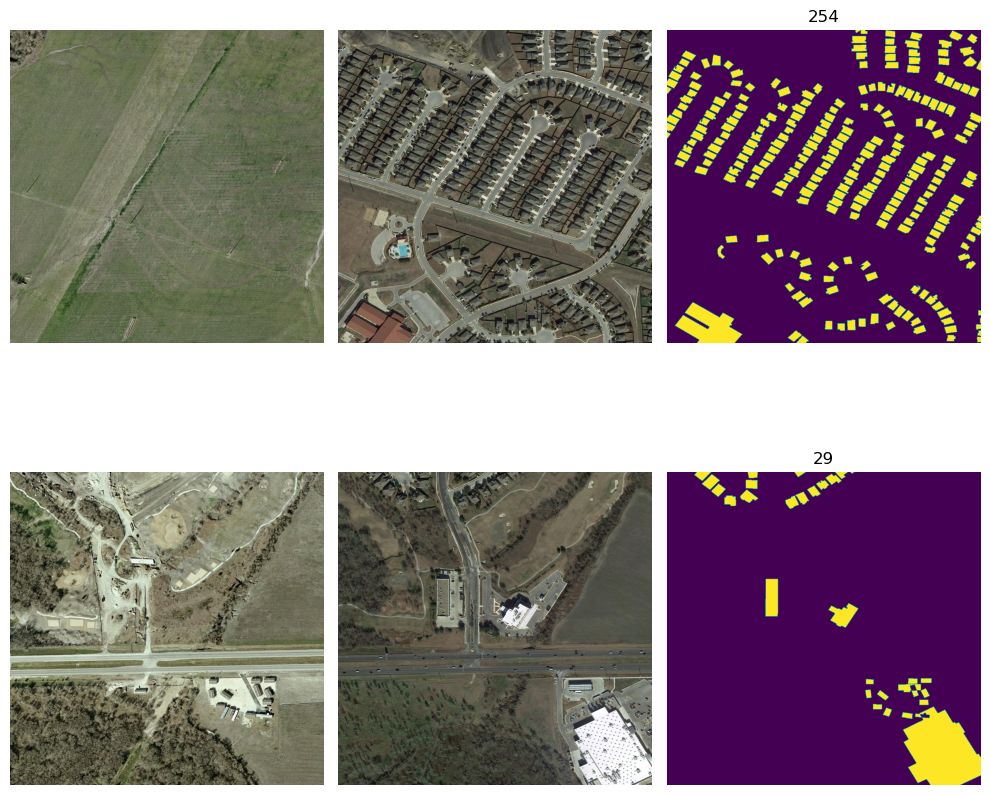

In [54]:
show_batch(batch)

In [68]:
import torchvision

# Convert the binary masks to grayscale images
images = [mask.unsqueeze(0).float() for mask in batch_masks][:30]

# Set the number of items per row
n_items_per_row = 10

# Compute the number of columns
n_columns = len(images) // n_items_per_row
if len(images) % n_items_per_row != 0:
    n_columns += 1

# Create a grid of images using make_grid with padding
grid = torchvision.utils.make_grid(images, nrow=n_items_per_row, padding=5, normalize=False, range=(0, 1), pad_value=1.)

# Convert the grid to a numpy array
grid_np = grid.numpy().transpose((1, 2, 0))

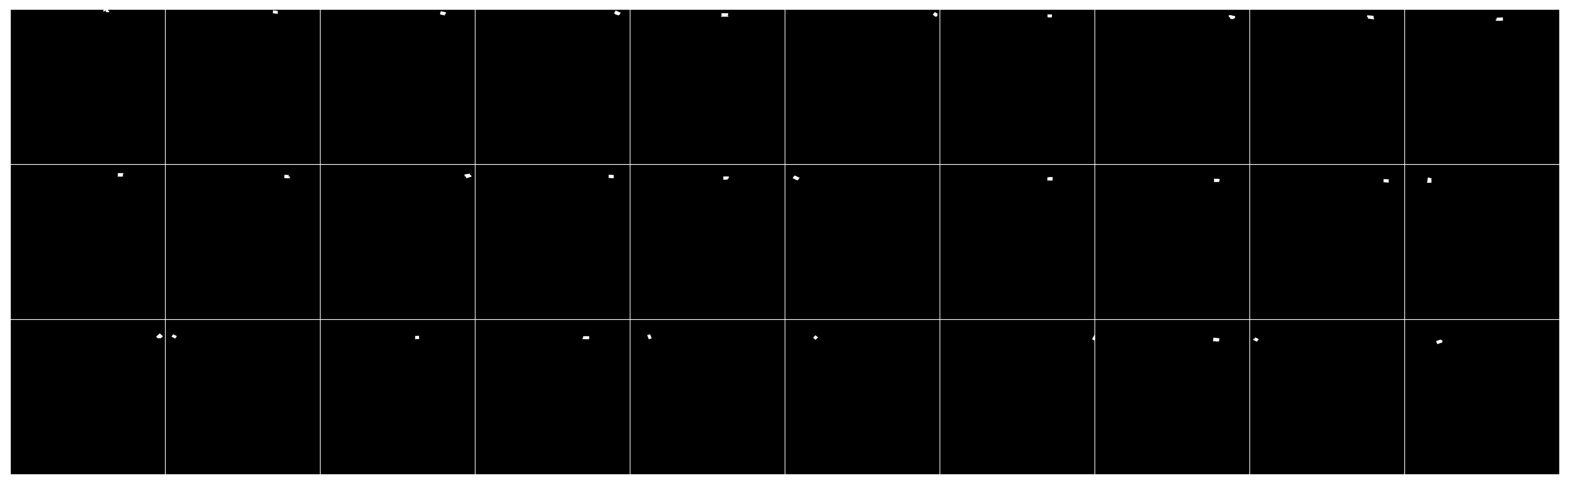

In [69]:

# Plot the grid using matplotlib
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(grid_np, cmap='gray',)
ax.set_axis_off()

In [56]:
labels_masks.shape

torch.Size([1024, 1024])

In [47]:
index = 0
norm_factor = 255
masks = torch.stack([ds[index]["label"], ds[index+1]["label"]], dim=0)

labels_masks = K.contrib.connected_components(
    masks.unsqueeze(1).to(torch.float) / norm_factor
)
# B x 1 x H x W => B x H x W
labels_masks = labels_masks.view(masks.shape[0], *labels_masks.shape[-2:])
print(len(labels_masks))

2


In [48]:
print(len(torch.unique(labels_masks[0])[1:]))
print(len(torch.unique(labels_masks[1])[1:]))

22
15


### Extract obj

In [5]:
from dataclasses import dataclass
from typing import Any, Dict, List, Sequence, Union
import numpy as np
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from torchmetrics import Metric
from tqdm import tqdm
from src.segment_any_change.config_run import load_default_exp_params
import torch
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform
from magic_pen.utils_io import load_levircd_sample
from segment_any_change.inference import load_partial_ds
import kornia as K
from segment_any_change.utils import to_numpy

In [18]:
ds_name="levir-cd"
dtype="test"
indices=np.arange(100)
dev=True
dummy=True
return_batch=True

params = load_exp_params(ds_name=ds_name, dev=dev)

print(params)

model = choose_model(is_debug=dummy, params=params)

ds = load_partial_ds(params.ds_name, dtype, indices)
in_metrics = load_default_metrics(**params.engine_metric)

engine_eval = MetricEngine(in_metrics=in_metrics)

dloader = torch.utils.data.DataLoader(ds, batch_size=params.batch_size, shuffle=False)

ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_b', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr', ds_name='levir-cd', th_change_proposals=70.0, points_per_side=5, points_per_batch=64, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci'}, exp_id='20240606_174122', exp_name='seganychange_repr')
DATASET SUBSET : 100


In [20]:
for i, batch in tqdm(enumerate(dloader), total=len(dloader), desc="Processing"):
    if i == 5:
        break

Processing:  10%|█████                                             | 5/50 [00:02<00:19,  2.30it/s]


In [21]:
preds = model(batch)

torch.Size([2, 1, 1024, 1024])


In [23]:
preds["masks"].shape

torch.Size([2, 1, 1024, 1024])

In [24]:
batch["label"].shape

torch.Size([2, 1024, 1024])

#### Extract obj from labels

In [145]:
import argparse
args = argparse.Namespace()
args.ds_name = "levir-cd"
args.dev = True
args.n_job_by_node = 1

In [149]:
vars(args)

{'ds_name': 'levir-cd', 'dev': True, 'n_job_by_node': 1}

In [114]:
from torch.nn.functional import one_hot

In [142]:
labels_masks = K.contrib.connected_components(
    batch["label"].unsqueeze(1).to(torch.float) / 255, 
    num_iterations=500
)
labels_masks = labels_masks.squeeze(1)

In [85]:
np.unique(to_numpy(batch["label"][0], transpose=False))

array([  0., 156., 255.], dtype=float32)

In [86]:
np.unique(to_numpy(batch["label"][1], transpose=False))

array([  0., 255.], dtype=float32)

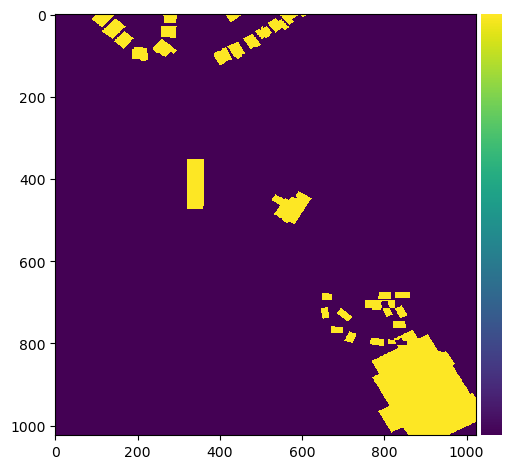

In [90]:
show_img(to_numpy(batch["label"][1], transpose=False))

In [91]:
labels_masks.shape

torch.Size([2, 1024, 1024])

In [123]:
def remap_values(remapping, x):
    index = torch.bucketize(x.ravel(), remapping[0])
    return remapping[1][index].reshape(x.shape)

uniques = torch.unique(labels_masks)
remapping = uniques, torch.arange(end=len(uniques))
remapped_batch = remap_values(remapping, labels_masks)

In [124]:
remapped_batch.shape

torch.Size([2, 1024, 1024])

In [125]:
torch.unique(remapped_batch[1])

tensor([  0, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
        268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
        282, 283])

In [126]:
torch.unique(remapped_batch[0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [127]:
remapped_batch = remapped_batch.long()
masks = one_hot(remapped_batch, len(uniques)) # view(remapped_batch.shape[0], -1)

In [141]:
remapped_batch.shape

torch.Size([2, 1024, 1024])

In [129]:
masks[1].sum(dim=(0, 1))

tensor([974774,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

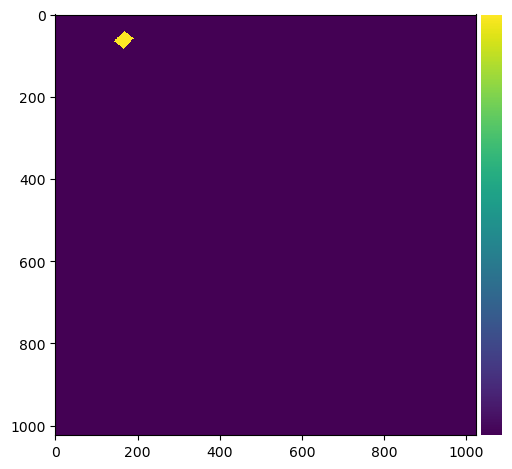

In [139]:
show_img(to_numpy(masks[1][...,-20], transpose=False))

In [94]:
unique_values = torch.unique(labels_masks.view(labels_masks.shape[0], -1), dim=1)

In [95]:
unique_values

tensor([[      0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,   16013.,   27367.,   38712.,   38837.,   46729.,
           49128.,   51939.,   64405.,   65334.,   74364.,   79591.,   90935.,
           91081.,   92052.,  100979.,  105552.,  106215.,  116534.,  120727.,
          121006.,  124900.,  126015.,  130682.,  130802.,  131195.,  134344.,
          134344.,  139263.,  146229.,  146476.,  164053.,  169058.,  172067.,
          183168.,  190703.,  194460.,  197654.,  199007.,  204726.,  204901.,
          206535.,  208145.,  208533.,  213729.,  215042.,  217043.,  217579.,
          219772.,  226033.,  226385.,  226672.,  227308.,  233672.,  238038.,
          239383.,  242944.,  245555.,  248906.,  25

In [105]:
n_obj = torch.count_nonzero(unique_values)
n_obj

tensor(3)

In [ ]:
mapping = {value.item(): i+1 for i, value in enumerate(unique_values)}


In [74]:
masks = []
ind = 1
for shape in torch.unique(labels_masks[ind])[1:]:
    loc = torch.where(batch["label"][ind] == shape, 1, 0)
    if not loc.numel() == 0:
        masks.append(loc)

In [75]:
len(masks)

3

In [76]:
all_masks = torch.stack(masks)

In [77]:
all_masks.shape

torch.Size([3, 1024, 1024])

In [88]:
torch.where(tensor == shape, 1, 0)

NameError: name 'tensor' is not defined

In [89]:
labels_masks.shape

torch.Size([2, 1024, 1024])

###### count max obj got from batch

In [86]:
labels_masks_flat = labels_masks.view(labels_masks.shape[0], -1)
n_max_ojb_batch = torch.unique(labels_masks_flat, dim=0)[0]

In [87]:
n_max_ojb_batch

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [82]:
labels_masks_flat.shape

torch.Size([2, 1048576])

In [49]:
n_max_ojb_batch

tensor([      0., 2074680.])

In [ ]:
    norm_factor = torch.max(masks)
    labels_masks = K.contrib.connected_components(
        masks.unsqueeze(1).to(torch.float) / norm_factor
    )

In [ ]:
masks = one_hot(labels_masks_flat, n_max_ojb_batch)

In [162]:
dummy = torch.zeros((4, 4)).long()
dummy[2, 2] = 1
#dummy[4:6, 4:6] = 1
dummy = dummy.repeat(3, 1, 1)
# dummy = torch.repeat_interleave(dummy.unsqueeze(1), 3, dim=1)

dummy[1, 0, 0] = 1
dummy[1, 3, 3] = 1
dummy[2, 2, 2] = 0

In [163]:
dummy.shape

torch.Size([3, 4, 4])

In [164]:
dummy

tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 0]],

        [[1, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]])

In [165]:
labels_masks = K.contrib.connected_components(
    dummy.unsqueeze(1).to(torch.float)
)

In [166]:
torch.unique(labels_masks.view(labels_masks.shape[0], -1), dim=1)

tensor([[ 0.,  0.,  0., 10.],
        [ 0., 16., 31., 31.],
        [ 0.,  0.,  0.,  0.]])

In [15]:
import torch

In [112]:
dummy = torch.zeros((10, 10)).long()
dummy[:3, :3] = 1
#dummy[4:6, 4:6] = 2
dummy = dummy.repeat(5, *dummy.shape[-2:])
dummy[1] = 9
dummy[2, 4:6, 4:6] = 22


In [98]:
dummy

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9],
         ...,
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0

In [46]:
dummy.shape

torch.Size([5, 10, 10])

In [47]:
from torch.nn.functional import one_hot

In [95]:
dummy_flat = dummy.view(dummy.shape[0],dummy.shape[1]*dummy.shape[2])

In [96]:
dummy_flat[0, ...]

tensor([1, 1, 1,  ..., 0, 0, 0])

In [97]:
dummy_flat.max(dim=1)

torch.return_types.max(
values=tensor([ 1,  9, 22,  1,  1]),
indices=tensor([  0,   0, 404,   0,   0]))

In [101]:
n_max_ojb_batch = torch.max(torch.max(dummy.view(dummy.shape[0],dummy.shape[1]*dummy.shape[2]), dim=1)[0])

masks = one_hot(dummy, n_max_ojb_batch)

* query prompt : sample n points from k connected components

Pour chaque image :
* prendre n_pts = min(n,k)
* sample n_pts connected compnents
* for each obj (connected component) get indices from mask where px == 1
  * draw 1 pts among indices => localization selected obj point
* 

In [49]:
masks.shape

torch.Size([5, 10, 10, 3])

In [51]:
masks[0,:, :,1]

tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [63]:
import torch.nn as nn

class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [65]:
input_tensor = torch.randn(2, 3, 1024, 1024)  # Example input
model_dummy = DummyModel()
img_embedding = model_dummy(input_tensor)  # Model inference


In [ ]:
img_embedding.shape